# Clustering
In this file, instructions how to approach the challenge can be found.

We can use different types of clustering algorithms:

- KMeans
- Hierarchical
- DBScan

In [37]:
# import libraries
import pandas as pd
import numpy as np
import folium # map visualization
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans # import k-means for clustering stage
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings # ignore warnings
warnings.filterwarnings('ignore')

## Segmentation of NYC neighborhoods

The goal of this project is to segment the neighborhoods of New York City into separate clusters and examine the information about them. For clustering, We can use any available information **except** demographic and economic indicators. We don't want to segment them based on those and we want to keep them for the **profiling of clusters** to see if there are any important economic differences between the created clusters.

In [38]:
# load our data files
venues_grouped = pd.read_csv('data/venues_grouped.csv')
venues_common = pd.read_csv('data/venues_common.csv')
lyft = pd.read_csv('data/lyftpickups.csv')


### Feature Engineering

Feature engineering plays a crucial role in this problem. We have limited amount of attributes so we need to create some features that will be important for segmentation.

- Google Places, Yelp and Foursquare APIs: number of venues, density of venues per square mile, number of restaurants, top restarurant category...
- Uber: number of rides per day in the neighborhood
- Meetups: number of events
- etc...

In [39]:
# add lyft pickups to venues_grouped if you want to use that data
venues_grouped = pd.merge(venues_grouped, lyft, how='left', on=['neighborhood', 'borough'])
venues_grouped.head()

,neighborhood,borough,ATM,Accounting and Bookkeeping Service,Advertising Agency,Afghan Restaurant,African Restaurant,Agriculture and Forestry Service,Airport Service,American Restaurant,...,Wine Store,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Youth Organization,Zoo,latitude,longitude,lyft_pickups
0,Allerton,Bronx,0.0,0.021277,0.0,0.0,0.0,0.0,0.0,0.042553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.865788,-73.859319,13
1,Annadale,Staten Island,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.538114,-74.178549,0
2,Arden Heights,Staten Island,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.549286,-74.185887,1
3,Arlington,Staten Island,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.635325,-74.165104,1
4,Arrochar,Staten Island,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.596313,-74.067124,17


In [181]:
# use this cell for only lyft pickups
#df = venues_grouped['lyft_pickups']

# scale lyft pickups column using min-max scaling
#scaler = MinMaxScaler()
#df = scaler.fit_transform(df.values.reshape(-1,1))

In [17]:
# use this cell for venue data
#df = venues_grouped.drop(['neighborhood', 'borough', 'latitude', 'longitude', 'lyft_pickups'], axis=1)

In [40]:
# use this cell for all data
df = venues_grouped.drop(['neighborhood', 'borough', 'latitude', 'longitude'], axis=1)

# scale lyft pickups column using min-max scaling
scaler = MinMaxScaler()
df['lyft_pickups'] = scaler.fit_transform(df['lyft_pickups'].values.reshape(-1,1))

### Feature Selection / Dimensionality Reduction¶
We need to apply different selection techniques to find out which one will be the best for our problems.

Original Features vs. PCA conponents?

Don't forget to scale the features for KMeans.

In [41]:
# do scree plot to see how many features are needed to explain the data
# pca to plot the principal component weight
pca = PCA()
pca.fit(df)
pca_data = pca.transform(df)

In [42]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
# only first 10
per_var = per_var[:10]
labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

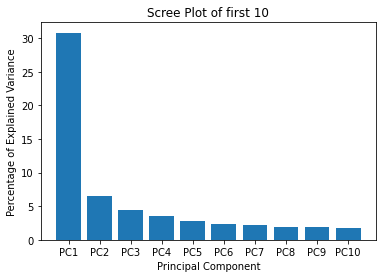

In [43]:


plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot of first 10')
plt.show()

### Evaluation

1. Check the segmentation evaluation metrics:
    - inertia
    - silhoutte score
2. How did you come up with the correct number of clusters?
3. Is there any relationship between the clusters and economic indicators? If yes, what does it mean?

You are required to share the file containing all NYC neighborhoods together with cluster_id with LighthouseLabs.

In [44]:
# function to plot distortion of kmeans clustering
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

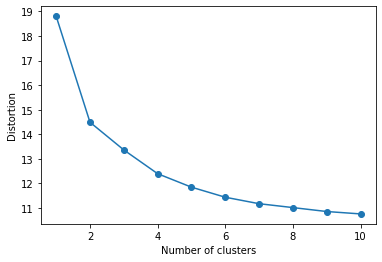

In [45]:
# inertia, elbow rule
plot_distortion(df, max_clusters=10)

In [46]:

# get silhouette score
sil = []
K_sil = range(2,10)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(df)
    labels = kmeans.labels_
    sil.append(silhouette_score(df, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 

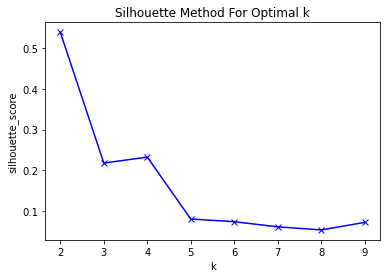

In [47]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.savefig('silo.png')

plt.show()
# plt.savefig('silo.png')

### Modeling

Use different attributes and clustering techniques and compare the created clusters:

- clustering only on restaurant features
- clustering only on Uber features
- clustering only on location
- combination of all

**Questions:**
1. Which clustering is the best?
2. How are neighborhoods split when we select only 2 clusters?
3. Are there any differences in housing and rental costs in different clusters?

In [48]:
# pca based on scree plot
pca = PCA(n_components=1)
df_pca = pca.fit_transform(df)

In [49]:
# do Kmeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_pca)

In [50]:
# add kmeans cluster labels to venues grouped dataframe
venues_grouped['cluster'] = kmeans.labels_

In [51]:
venues_grouped

,neighborhood,borough,ATM,Accounting and Bookkeeping Service,Advertising Agency,Afghan Restaurant,African Restaurant,Agriculture and Forestry Service,Airport Service,American Restaurant,...,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Youth Organization,Zoo,latitude,longitude,lyft_pickups,cluster
0,Allerton,Bronx,0.0,0.021277,0.0,0.0,0.0,0.0,0.0,0.042553,...,0.0,0.0,0.0,0.0,0.0,0.0,40.865788,-73.859319,13,1
1,Annadale,Staten Island,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,40.538114,-74.178549,0,1
2,Arden Heights,Staten Island,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,40.549286,-74.185887,1,1
3,Arlington,Staten Island,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,40.635325,-74.165104,1,1
4,Arrochar,Staten Island,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,40.596313,-74.067124,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Woodhaven,Queens,0.0,0.023256,0.0,0.0,0.0,0.0,0.0,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,40.689887,-73.858110,213,1
302,Woodlawn,Bronx,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.032258,...,0.0,0.0,0.0,0.0,0.0,0.0,40.898273,-73.867315,21,1
303,Woodrow,Staten Island,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,40.541968,-74.205246,0,1
304,Woodside,Queens,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.020000,...,0.0,0.0,0.0,0.0,0.0,0.0,40.746349,-73.901842,795,3


In [193]:
# add latitude and longitude from lyft to venues grouped dataframe
# venues_grouped = pd.merge(venues_grouped, lyft, how='left', on=['neighborhood', 'borough'])

In [52]:
# new york latitude and longitude
latitude = 40.7128
longitude = -74.0060


# create a map to display clusters
def color_clust(cluster):
    if cluster == 0:
        return 'green'
    elif cluster == 1:
        return 'blue'
    elif cluster == 2:
        return 'red'
    elif cluster == 3:
        return 'yellow'
    elif cluster == 4:
        return 'orange'
    elif cluster == 5:
        return 'purple'


map_newyork_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# add color coded cluster circles to map
for hood, lat, lng, label in zip(venues_grouped['neighborhood'], venues_grouped['latitude'], venues_grouped['longitude'], venues_grouped['cluster']):
    nodename = '{}, {}'.format(label, hood)
    folium.Circle(location=[lat, lng],
    stroke=False, 
    fill_color=color_clust(label),
    radius=900,
    fill_opacity=0.6,
    tooltip=nodename).add_to(map_newyork_clusters)

# change map save location for different clusters
map_newyork_clusters.save('data/clusters_all.html')
map_newyork_clusters

In [53]:
# make a dataframe with each neighborhoods top 10 venues
num_top_venues = 10

columns = ['cluster']
for i in range(num_top_venues):
    columns.append(str(i+1) + ' common')

cluster_common_venues = pd.DataFrame(columns=columns)

In [54]:

venues_common['cluster'] = kmeans.labels_
# unique cluster labels
labels = set(kmeans.labels_)

# get common venues for each cluster
for label in labels:
    row = [label]
    for venue in range(1, 11):
        topvenue = venues_common.query('cluster == {}'.format(label))['{} common'.format(venue)].value_counts().index.to_list()[0]
        row.append(topvenue)
    # add row to dataframe
    cluster_common_venues = cluster_common_venues.append(pd.DataFrame([row], columns=columns), ignore_index=True)


In [55]:
# print common venues grouped by cluster
cluster_common_venues

,cluster,1 common,2 common,3 common,4 common,5 common,6 common,7 common,8 common,9 common,10 common
0,0,Restaurant,American Restaurant,Art Gallery,Night Club,Wine Bar,New American Restaurant,Café,Bar,American Restaurant,Scenic Lookout
1,1,Pizzeria,Pizzeria,Pizzeria,Pizzeria,Pizzeria,Bagel Shop,Bagel Shop,Grocery Store / Supermarket,Bagel Shop,Bakery
2,2,Restaurant,American Restaurant,Bakery,Bakery,Bakery,Café,Grocery Store / Supermarket,Playground,Pizzeria,Burger Joint
3,3,Restaurant,Bakery,Coffee Shop,Restaurant,Bakery,Bar,Bakery,Playground,Café,Bar
4,4,Restaurant,Cocktail Bar,Bakery,Café,Bar,American Restaurant,Grocery Store / Supermarket,Bakery,Bookstore,River


### Notes
- Tried kmeans on just lyft data, just venue data and both together.
- Lyft rides data really dominates as a principal component and clusters change